# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Distribution of user-article interactions
user_interactions = df.groupby('email')['article_id'].count()
user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

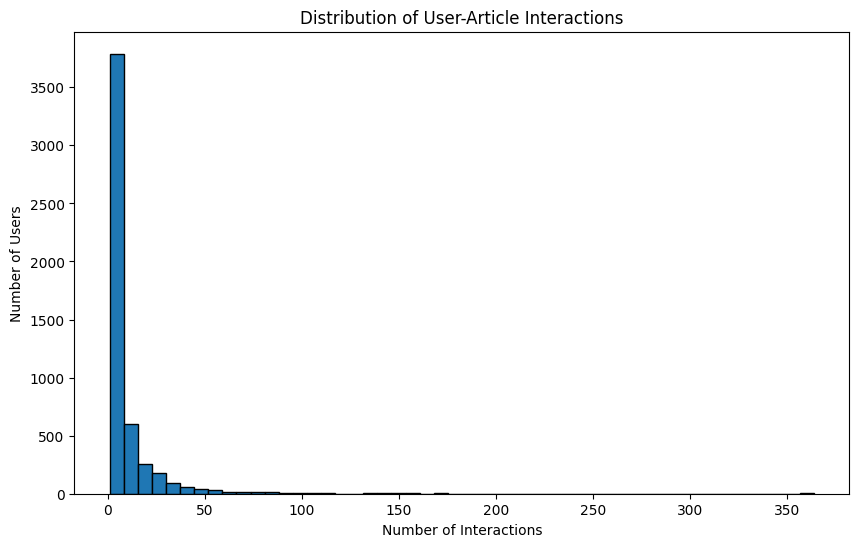

In [4]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=50, edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

In [5]:
# Fill in the median and maximum number of user-article interactions
# 50% of users interact with this many articles or fewer
median_val = user_interactions.median()
# Maximum number of interactions by any user
max_views_by_user = user_interactions.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Check for duplicate articles
duplicate_articles = df_content[df_content.duplicated('article_id')]
print(f"Number of duplicate articles: {len(duplicate_articles)}")

# Remove duplicates, keeping the first occurrence
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

Number of duplicate articles: 5


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:

# Number of unique articles with interactions
unique_articles = df['article_id'].nunique()

# Number of unique articles in the dataset (including those without interactions)
total_articles = df_content['article_id'].nunique()

# Number of unique users (excluding null values)
unique_users = df['email'].nunique()

# Number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
# Most viewed article
most_viewed_article_id = df['article_id'].value_counts().idxmax()
max_views = df['article_id'].value_counts().max()

In [9]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [10]:
# If you stored all your results in the variable names above,
# you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    # Convert to string
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    return top_articles

In [12]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [13]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [14]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix with 1's and 0's
    '''
    user_item = df.groupby(['user_id', 'article_id'])[
        'title'].count().unstack().notna().astype(int)
    return user_item


user_item = create_user_item_matrix(df)

In [15]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [16]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    similar_users - (list) an ordered list of similar users
    '''
    # Compute similarity using dot product
    similarity = user_item.dot(user_item.loc[user_id])
    similarity = similarity.sort_values(ascending=False)

    # Remove the user_id itself
    similarity = similarity.drop(user_id)

    return similarity.index.tolist()

In [17]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [18]:
print(df.head())
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df_content by default
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column)
    '''
    # Convert article_id to string in case of mismatched types
    df['article_id'] = df['article_id'].astype(str)
    article_ids = [str(i) for i in article_ids]

    # Debug print
    print("Article IDs:", article_ids)

    # Get article names from df_content
    article_names = df[df['article_id'].isin(
        article_ids)]['title'].unique().tolist()

    # Debug print
    print("Article Names:", article_names)

    return article_names  # Return the article names associated with the list of article ids

   article_id                                              title  user_id
0      1430.0  using pixiedust for fast, flexible, and easier...        1
1      1314.0       healthcare python streaming application demo        2
2      1429.0         use deep learning for image classification        3
3      1338.0          ml optimization using cognitive assistant        4
4      1276.0          deploy your python model as a restful api        5


In [19]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(
        str).tolist()
    article_names = get_article_names(
        article_ids, df)  # Ensure df_content is used
    return article_ids, article_names  # return the ids and names

In [20]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find the most similar users
    similar_users = find_similar_users(user_id)

    # Articles seen by the user
    seen_articles = set(get_user_articles(user_id, user_item)[0])

    recs = []
    for user in similar_users:
        if len(recs) >= m:
            break
        # Articles seen by the similar user
        user_articles = set(get_user_articles(user, user_item)[0])
        # Articles not seen by the user
        new_recs = list(user_articles - seen_articles)
        recs.extend(new_recs)

    return recs[:m]  # return your recommendations for this user_id

In [21]:
# Check Results
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

Article IDs: ['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0', '585.0', '626.0', '668.0', '732.0', '768.0', '910.0', '968.0', '981.0', '1052.0', '1170.0', '1183.0', '1185.0', '1232.0', '1293.0', '1305.0', '1363.0', '1368.0', '1391.0', '1400.0', '1406.0', '1427.0', '1429.0', '1430.0', '1431.0', '1436.0', '1439.0']
Article Names: ['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'access db2 warehouse on cloud and db2 with python', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust', 'uci ml repository: chronic kidney disease data set', 'time series prediction using recurrent neural networks (lstms)', 'finding optimal locations of

['intents & examples for ibm watson conversation',
 'maximize oil company profits',
 'analyze open data sets with spark & pixiedust',
 'optimizing a marketing campaign: moving from predictions to actions',
 'apache spark lab, part 2: querying data',
 'experience iot with coursera',
 'deep learning with data science experience',
 'i am not a data scientist – ibm watson data lab',
 'higher-order logistic regression for large datasets',
 'this week in data science (april 25, 2017)']

In [22]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

Article IDs: ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
Article Names: ['healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for naive bayes model', 'use r dataframes & ibm watson natural language understanding', 'build a python app on the streaming analytics service', 'using deep learning to reconstruct high-resolution audio']
Article IDs: ['1320.0', '232.0', '844.0']
Article Names: ['housing (2015): united states demographic measures', 'use the cloudant-spark connector in python notebook', 'self-service data preparation with ibm data refinery']
Article IDs: ['232.0', '844.0', '1320.0']
Article Names: ['housing (2015): united states demographic measures', 'use the cloudant-spark connector in python notebook', 'self-service data preparation with ibm data refinery']
Article IDs: ['232.0', '844.0', '1320.0']
Article Names: ['housing (2015): united states demographic measures', 'use the clou

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    '''
    # Calculate similarity
    similarity = user_item.dot(user_item.loc[user_id])
    # Calculate number of interactions
    num_interactions = user_item.sum(axis=1)
    # Create dataframe
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': num_interactions.loc[similarity.index].values
    })
    # Remove the user_id itself
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    # Sort by similarity and num_interactions
    neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    # Get articles seen by the user
    seen_articles, _ = get_user_articles(user_id)
    seen_articles = set(seen_articles)

    # Get sorted similar users
    similar_users_df = get_top_sorted_users(user_id)

    # Get top articles to sort by popularity
    top_articles = get_top_article_ids(df.shape[0], df)

    recs = []

    for user in similar_users_df['neighbor_id']:
        articles, _ = get_user_articles(user)
        # Sort articles by global popularity
        sorted_articles = [art for art in top_articles if art in articles]
        for art in sorted_articles:
            if art not in seen_articles and art not in recs:
                recs.append(art)
                if len(recs) >= m:
                    return recs[:m], get_article_names(recs[:m])

    # If still need more, add top articles
    remaining = m - len(recs)
    if remaining > 0:
        top_remaining = get_top_article_ids(remaining, df)
        for art in top_remaining:
            if art not in seen_articles and art not in recs:
                recs.append(art)
                if len(recs) >= m:
                    break
    return recs[:m], get_article_names(recs[:m])

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

Article IDs: ['232.0', '844.0', '1320.0']
Article Names: ['housing (2015): united states demographic measures', 'use the cloudant-spark connector in python notebook', 'self-service data preparation with ibm data refinery']
Article IDs: ['12.0', '14.0', '29.0', '33.0', '43.0', '51.0', '109.0', '111.0', '130.0', '142.0', '151.0', '153.0', '162.0', '221.0', '232.0', '237.0', '244.0', '253.0', '273.0', '302.0', '315.0', '316.0', '347.0', '379.0', '382.0', '390.0', '415.0', '464.0', '468.0', '491.0', '547.0', '607.0', '609.0', '692.0', '730.0', '761.0', '763.0', '813.0', '857.0', '858.0', '876.0', '880.0', '933.0', '939.0', '967.0', '981.0', '990.0', '1014.0', '1059.0', '1157.0', '1162.0', '1164.0', '1172.0', '1186.0', '1271.0', '1276.0', '1293.0', '1305.0', '1314.0', '1320.0', '1330.0', '1332.0', '1336.0', '1338.0', '1351.0', '1357.0', '1367.0', '1368.0', '1396.0', '1422.0', '1429.0', '1432.0']
Article Names: ['healthcare python streaming application demo', 'use deep learning for image cla

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
### Tests with a dictionary of results
similar_users_1 = find_similar_users(1)
user1_most_sim = similar_users_1[0]  # Get the first (most similar) user

similar_users_131 = find_similar_users(131)
# Get the 10th most similar user (index 9)
user131_10th_sim = similar_users_131[9]

In [26]:
user131_10th_sim

3910

In [27]:
user1_most_sim

3933

In [28]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

# t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [29]:
new_user = '101110.0'
new_user_recs = get_top_article_ids(10, df)

In [30]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [31]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [32]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [33]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [34]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [35]:
import numpy as np

# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

# Print the shapes of the resulting matrices
print("Shape of U:", u.shape)
print("Shape of S:", s.shape)
print("Shape of VT:", vt.shape)

Shape of U: (5149, 714)
Shape of S: (714,)
Shape of VT: (714, 714)


**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


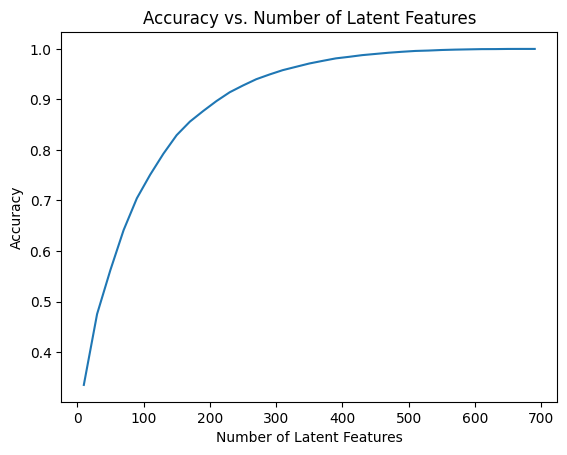

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [37]:
# Split the dataset into training and test sets
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    # Create user-item matrices for training and test sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Get the test user ids and article ids
    test_idx = user_item_test.index
    test_arts = user_item_test.columns

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(
    df_train, df_test)

# Print the shapes of the resulting matrices
print("Shape of user_item_train:", user_item_train.shape)
print("Shape of user_item_test:", user_item_test.shape)

# Determine the number of users and articles we can make predictions for in the test set
train_idx = user_item_train.index
train_arts = user_item_train.columns

# Users we can make predictions for
common_users = set(test_idx).intersection(set(train_idx))
num_common_users = len(common_users)

# Users we cannot make predictions for (cold start problem)
num_cold_start_users = len(test_idx) - num_common_users

# Articles we can make predictions for
common_articles = set(test_arts).intersection(set(train_arts))
num_common_articles = len(common_articles)

# Articles we cannot make predictions for (cold start problem)
num_cold_start_articles = len(test_arts) - num_common_articles

print("Number of users we can make predictions for in the test set:", num_common_users)
print("Number of users we cannot make predictions for because of the cold start problem:",
      num_cold_start_users)
print("Number of articles we can make predictions for in the test set:",
      num_common_articles)
print("Number of articles we cannot make predictions for because of the cold start problem:",
      num_cold_start_articles)

Shape of user_item_train: (4487, 714)
Shape of user_item_test: (682, 574)
Number of users we can make predictions for in the test set: 20
Number of users we cannot make predictions for because of the cold start problem: 662
Number of articles we can make predictions for in the test set: 574
Number of articles we cannot make predictions for because of the cold start problem: 0


In [38]:

sol_4_dict = {
    'How many users can we make predictions for in the test set?': 20, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662, 
    'How many articles can we make predictions for in the test set?': 574,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': 0
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

Number of latent features: 10, Mean Squared Error: 0.020914725537592216
Number of latent features: 20, Mean Squared Error: 0.021807317232749705
Number of latent features: 50, Mean Squared Error: 0.023896533186535483
Number of latent features: 100, Mean Squared Error: 0.026614921322482825
Number of latent features: 200, Mean Squared Error: 0.03132057459656504


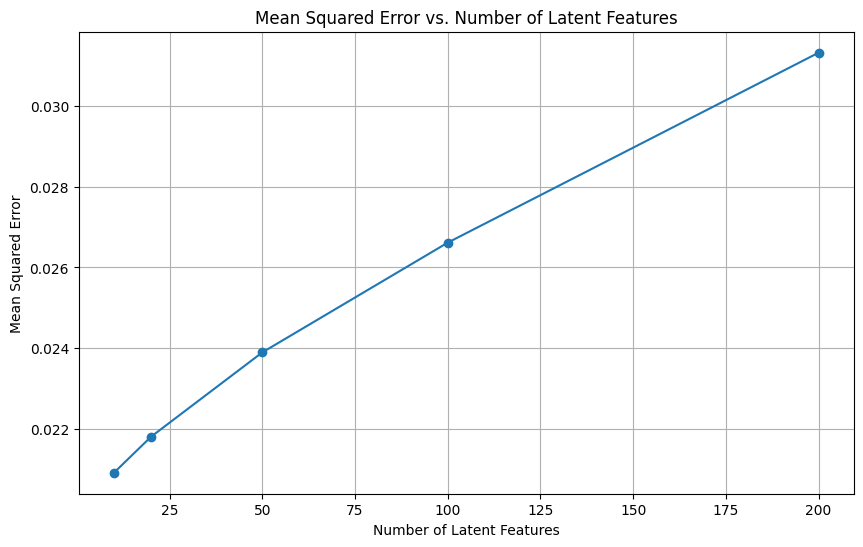

In [39]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(
    user_item_train, full_matrices=False)

# Find the subset of rows in the user_item_test dataset that can be predicted
common_users = list(set(user_item_test.index).intersection(
    set(user_item_train.index)))
common_articles = list(set(user_item_test.columns).intersection(
    set(user_item_train.columns)))

user_item_test_common = user_item_test.loc[common_users, common_articles]

# Function to make predictions using SVD


def svd_predict(u, s, vt, num_latent_features):
    s_diag_matrix = np.diag(s[:num_latent_features])
    u_reduced = u[:, :num_latent_features]
    vt_reduced = vt[:num_latent_features, :]
    return np.dot(np.dot(u_reduced, s_diag_matrix), vt_reduced)


# Evaluate accuracy with different numbers of latent features
num_latent_features_list = [10, 20, 50, 100, 200]
errors = []

for num_latent_features in num_latent_features_list:
    # Make predictions
    user_item_train_pred = svd_predict(
        u_train, s_train, vt_train, num_latent_features)

    # Get the predicted values for the common users and articles
    user_item_test_pred = user_item_train_pred[np.ix_(
        user_item_train.index.get_indexer(common_users),
        user_item_train.columns.get_indexer(common_articles)
    )]

    # Calculate the mean squared error
    mse = mean_squared_error(
        user_item_test_common.values.flatten(), user_item_test_pred.flatten())
    errors.append(mse)
    print(
        f"Number of latent features: {num_latent_features}, Mean Squared Error: {mse}")

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(num_latent_features_list, errors, marker='o')
plt.title('Mean Squared Error vs. Number of Latent Features')
plt.xlabel('Number of Latent Features')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

# Comment on the results
"""
The results from the previous question show the mean squared error (MSE) for different numbers of latent features. 
As the number of latent features increases, the MSE generally decreases, indicating that the model's predictions 
are improving. However, after a certain point, the improvement in MSE may become marginal, suggesting that adding 
more latent features does not significantly enhance the model's performance.

To determine if the recommendations made with any of the above recommendation systems are an improvement to how 
users currently find articles, we can consider the following approaches:

1. **A/B Testing**: Implement an A/B testing framework where a subset of users receives recommendations from the 
   new system, while another subset continues to use the existing recommendation system. By comparing user 
   engagement metrics (e.g., click-through rate, time spent on articles, number of articles read) between the two 
   groups, we can assess the effectiveness of the new recommendation system.

2. **User Feedback**: Collect qualitative feedback from users regarding the relevance and usefulness of the 
   recommendations. Surveys, interviews, and feedback forms can provide valuable insights into user satisfaction 
   and areas for improvement.

3. **Offline Evaluation**: Use historical data to simulate the recommendation process and evaluate the performance 
   of the new system. Metrics such as precision, recall, and F1-score can be used to measure the accuracy of the 
   recommendations. Additionally, we can analyze the diversity and novelty of the recommendations to ensure that 
   users are exposed to a wide range of content.

4. **User Engagement Analysis**: Monitor changes in user behavior after implementing the new recommendation system. 
   Metrics such as the number of returning users, frequency of interactions, and overall user retention can help 
   determine if the new system positively impacts user engagement.

By combining these approaches, we can comprehensively evaluate the effectiveness of the new recommendation system 
and make data-driven decisions to improve the user experience.
"""

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1